<a href="https://colab.research.google.com/github/asiyabb/Emotion-Detection-FER2013/blob/main/02_train_transfer_learning_7class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U numpy scikit-learn tensorflow-datasets

In [2]:
# Cell 1 — Environment checks
import os, sys, math, time, json
import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))


TensorFlow: 2.19.0
GPU available: False


In [3]:
 # Cell 2 — (Recommended) Install extras
# Colab usually has TF already; we only add tfds + sklearn for confusion matrix.
!pip -q install -U tensorflow-datasets scikit-learn

import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [4]:
# Cell 3 — Hyperparameters
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
NUM_CLASSES = 7

IMG_SIZE = (96, 96)     # model input size
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 3e-4
BACKBONE = "MobileNetV2"   # options: MobileNetV2, EfficientNetB0

AUTOTUNE = tf.data.AUTOTUNE


In [5]:
# Cell 6 (Optional) — Folder-based loading (ONLY if you have your own folders)
# Uncomment and edit paths if you want this instead of TFDS.

# from tensorflow.keras.utils import image_dataset_from_directory
# TRAIN_DIR = "/content/data/train"
# VAL_DIR   = "/content/data/val"
#
# train_ds = image_dataset_from_directory(
#     TRAIN_DIR, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
# ).map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).prefetch(AUTOTUNE)
#
# val_ds = image_dataset_from_directory(
#     VAL_DIR, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
# ).map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y)).prefetch(AUTOTUNE)
#
# # If you use folder-based loading:
# CLASS_NAMES = train_ds.class_names
# NUM_CLASSES = len(CLASS_NAMES)
#
# print("Classes:", NUM_CLASSES, CLASS_NAMES)


In [6]:
# Cell 7 — Build transfer-learning model
def get_backbone(name: str, input_shape):
    name = name.lower()
    if name == "mobilenetv2":
        base = tf.keras.applications.MobileNetV2(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    elif name == "efficientnetb0":
        base = tf.keras.applications.EfficientNetB0(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError(f"Unknown BACKBONE={name}. Use MobileNetV2 or EfficientNetB0.")
    return base, preprocess_input

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
base_model, backbone_preprocess = get_backbone(BACKBONE, input_shape)

base_model.trainable = False  # freeze for warmup

inputs = tf.keras.Input(shape=(96, 96, 1))
x = backbone_preprocess(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name=f"FER2013_{BACKBONE}")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "FER2013_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/FER2013'

Mounted at /content/drive


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


Found 35888 files belonging to 2 classes.
Using 28711 files for training.
Found 35888 files belonging to 2 classes.
Using 7177 files for validation.
Classes: ['test', 'train']


In [9]:
# Cell 8 — Train (frozen backbone warmup)
ckpt_path = "/content/best_model.keras"

cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=4, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs
)


Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.7027 - loss: 0.7758
Epoch 1: val_acc improved from -inf to 0.79365, saving model to /content/best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 4555s 10s/step - acc: 0.7028 - loss: 0.7755 - val_acc: 0.7936 - val_loss: 0.5362 - learning_rate: 3.0000e-04
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - acc: 0.7783 - loss: 0.5617
Epoch 2: val_acc improved from 0.79365 to 0.79406, saving model to /content/best_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 325s 724ms/step - acc: 0.7783 - loss: 0.5616 - val_acc: 0.7941 - val_loss: 0.5220 - learning_rate: 3.0000e-04
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - acc: 0.7911 - loss: 0.5309
Epoch 3: val_acc did not improve from 0.79406
449/449 ━━━━━━━━━━━━━━━━━━━━ 302s 672ms/step - acc: 0.7911 - loss: 0.5308 - val_acc: 0.7939 - val_loss: 0.5220 - learning_rate: 3.0000e-04
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - acc: 0.7977 - loss: 0.5179
Epoch 4: val_acc improved 

In [10]:
# Cell 9 — Fine-tune (unfreeze last layers)
# Fine-tuning helps but can overfit; keep LR small.
base_model.trainable = True

# Unfreeze only the last N layers
N = 40
for layer in base_model.layers[:-N]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(5, EPOCHS//2),
    callbacks=cbs
)


Epoch 1/7
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - acc: 0.7682 - loss: 0.5717
Epoch 1: val_acc did not improve from 0.79420
449/449 ━━━━━━━━━━━━━━━━━━━━ 444s 962ms/step - acc: 0.7682 - loss: 0.5717 - val_acc: 0.7942 - val_loss: 0.5271 - learning_rate: 1.0000e-05
Epoch 2/7
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - acc: 0.7854 - loss: 0.5266
Epoch 2: val_acc did not improve from 0.79420
449/449 ━━━━━━━━━━━━━━━━━━━━ 457s 995ms/step - acc: 0.7854 - loss: 0.5266 - val_acc: 0.7939 - val_loss: 0.5323 - learning_rate: 1.0000e-05
Epoch 3/7
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - acc: 0.7919 - loss: 0.5013
Epoch 3: val_acc did not improve from 0.79420

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
449/449 ━━━━━━━━━━━━━━━━━━━━ 478s 941ms/step - acc: 0.7919 - loss: 0.5013 - val_acc: 0.7931 - val_loss: 0.5351 - learning_rate: 1.0000e-05
Epoch 4/7
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - acc: 0.7946 - loss: 0.4849
Epoch 4: val_acc did not improve from 0.

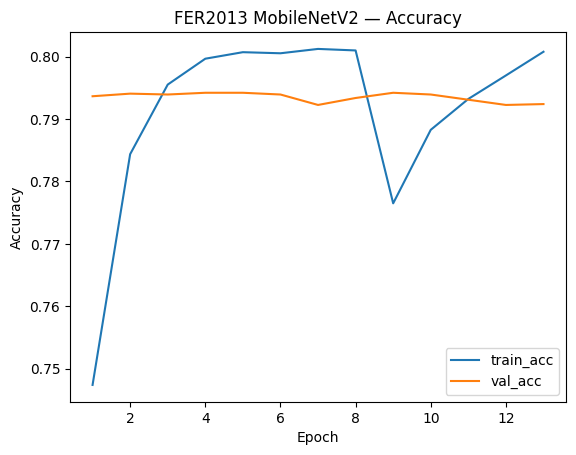

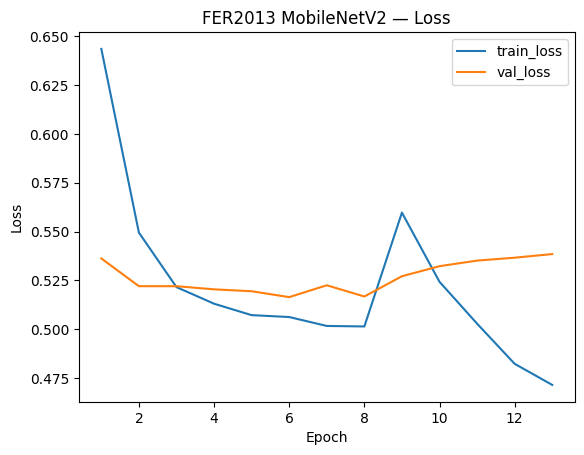

In [11]:
# Cell 10 — Plot training curves
def plot_history(histories, title="Training"):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for h in histories:
        acc += h.history.get("acc", [])
        val_acc += h.history.get("val_acc", [])
        loss += h.history.get("loss", [])
        val_loss += h.history.get("val_loss", [])
    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, val_acc, label="val_acc")
    plt.title(title + " — Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title(title + " — Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.show()

plot_history([history1, history2], title=f"FER2013 {BACKBONE}")


In [13]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

CLASS_NAMES = [
    "Angry", "Disgust", "Fear",
    "Happy", "Sad", "Surprise", "Neutral"
]

labels = list(range(7))  # force 7-class evaluation

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    )
)


Classification report:
              precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000      1477
     Disgust     0.7942    1.0000    0.8853      5700
        Fear     0.0000    0.0000    0.0000         0
       Happy     0.0000    0.0000    0.0000         0
         Sad     0.0000    0.0000    0.0000         0
    Surprise     0.0000    0.0000    0.0000         0
     Neutral     0.0000    0.0000    0.0000         0

    accuracy                         0.7942      7177
   macro avg     0.1135    0.1429    0.1265      7177
weighted avg     0.6308    0.7942    0.7031      7177



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (7).

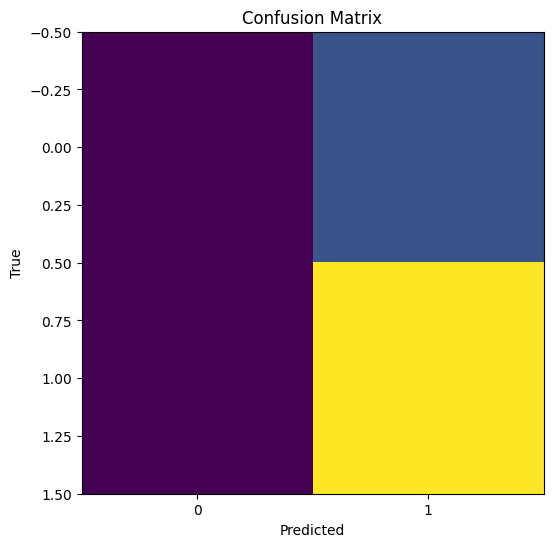

In [15]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
plt.colorbar()
plt.tight_layout()
plt.show()
